**Processamento Digital de Imagens - 2022/01**<br/>
**Engenharia da Computação**<br/>
**Aluno:** Gabriel Soares Baptista, 2018102117<br/>

### Questão 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict

### Funções auxiliares

In [2]:
def get_intensities(image: np.array) -> Dict[int, int]:
    """
    Retorna a quantidade de pixels com a mesma intensidade.
    Funçao utilizada para equalizar o histograma da imagem.
    """
    new_intensities = [0 for i in range(256)]

    m, n = image.shape

    for i in range(m):
        for j in range(n):
            new_intensities[image[i][j]] += 1

    return new_intensities


def equalize_gray_scaled_image(image: np.array) -> np.array:
    """
    Faz a equalização de histograma da imagem informada.
    """
    M, N = image.shape
    intensities = get_intensities(image)
    probabilities = {i: n/(M*N) for i, n in enumerate(intensities)}
    probabilities_list = list(probabilities.values())

    # Calcula a probabilidade acumulada de cada intensidade
    equalized_intensities = {
    i: round(255 * sum(probabilities_list[:i]))
    for i in range(256)}

    # Cria a imagem resultante
    equalized_image = image.copy()

    for i in range(M):
        for j in range(N):
            equalized_image[i, j] = equalized_intensities[equalized_image[i, j]]

    return equalized_image


def get_theta(r: int, g: int, b: int) -> np.float32:
    '''
    Retorna o ângulo theta utilizado na conversão de RGB para
    HSI, note que o valor de retorno é em graus e não em 
    radianos.
    '''
    num = 0.5*((r-g) + (r-b))
    den = ((r-g)**2 + (r-b)*(g-b))**0.5

    if den > 0:
        return np.rad2deg(np.arccos(num / den))
    else:
        return 90


def rgb_to_hsi(image: np.array) -> np.array:
    '''
    Converte a imagem informada de RGB para HSI, isto é, cada
    valor de pixel na imagem de retorno irá representar as
    componentes HSI normalizadas (no intervalo [0, 1]).
    '''
    hsi_image = []

    for row in image:
        new_row = []

        for pixel in row:
            r, g, b = pixel

            # normaliza os valores
            r /= 255
            g /= 255
            b /= 255

            # pega as componentes hsi
            theta = get_theta(r, g, b)
            h = theta if b <= g else 360 - theta
            h /= 360
            if (r == 0 and g == 0 and b == 0):
                s = 1
            else:
                s = 1 - (3/(r+g+b)) * np.min([r, g, b])
            i = (r+g+b)/3

            new_row.append([h, s, i])
        hsi_image.append(new_row)

    return np.array(hsi_image, dtype=np.float32)


def hsi_to_rgb(image: np.array) -> np.array:
    '''
    Converte a imagem informada de HSI para RGB, isto é, cada
    valor de pixel na imagem de retorno irá representar as
    componentes RGB (já no intervalo [0, 255]).
    '''
    rgb_image = []

    for row in image:
        new_row = []

        for pixel in row:
            h, s, i = pixel

            # volta o ângulo para o intervalo [0, 360]
            h *= 360

            # encontra o setor pelo ângulo
            if 0 <= h < 120:
                b = i*(1 - s)
                r = i*(1 + (s*np.cos(np.deg2rad(h)))/(np.cos(np.deg2rad(60 - h))))
                g = 3*i - (r + b)
            elif 120 <= h < 240:
                h -= 120
                r = i*(1 - s)
                g = i*(1 + (s*np.cos(np.deg2rad(h)))/(np.cos(np.deg2rad(60 - h))))
                b = 3*i - (r + g)
            else:
                h -= 240
                g = i*(1 - s)
                b = i*(1 + (s*np.cos(np.deg2rad(h)))/(np.cos(np.deg2rad(60 - h))))
                r = 3*i - (g + b)

            new_row.append([r * 255, g * 255, b * 255])
        rgb_image.append(new_row)

    return np.array(rgb_image, dtype=np.uint8)


def plot_hsi(image: np.array) -> None:
    '''
    Imprime cada canal da imagem separadamente. Utilizada
    para mostrar cada componente HSI da imagem convertida.
    '''
    _, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image[:, :, 0], cmap='gray')
    axs[0].set_title('H channel')
    axs[1].imshow(image[:, :, 1], cmap='gray')
    axs[1].set_title('S channel')
    axs[2].imshow(image[:, :, 2], cmap='gray')
    axs[2].set_title('I channel')
    plt.show()


def equalize_rgb_image(image: np.array):
    equalized_image: np.array = np.zeros(shape=image.shape, dtype='uint8')
    equalized_image[:, :, 0] = equalize_gray_scaled_image(image[:, :, 0])
    equalized_image[:, :, 1] = equalize_gray_scaled_image(image[:, :, 1])
    equalized_image[:, :, 2] = equalize_gray_scaled_image(image[:, :, 2])
    return equalized_image


def equalize_hsi_image(image: np.array):
    ''' . '''
    hsi_image = rgb_to_hsi(image)

    i_channel = np.array(hsi_image[:, :, 2] * 255, dtype='uint8')
    i_channel = equalize_gray_scaled_image(i_channel)
    i_channel = np.array(i_channel / 255, dtype='float32')

    #
    hsi_image[:, :, 2] = i_channel

    return hsi_image


def image_histogram(image: np.array) -> None:
    """
    Plota o histograma de cada um dos canais da imagem
    informada como um np.array.
    """
    _, axs = plt.subplots(1, 3, figsize=(25, 5))
    channel_titles = ['Red', 'Green', 'Blue']

    for channel in range(3):
        histogram = {i: 0 for i in range(256)}

        for row in image[:, :, channel]:
            for pixel in row:
                histogram[pixel] += 1

        axs[channel].bar(histogram.keys(), histogram.values())
        axs[channel].set_title(channel_titles[channel])
    plt.show()



### Resolução

Primeiro lemos a imagem com cores que iremos equalizar.

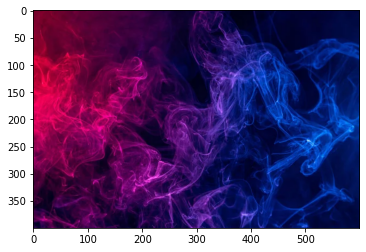

In [3]:
image = plt.imread('../images/colorful-red-blue.png')
plt.imshow(image)
plt.show()

Como a imagem se trata de uma imagem colorida com valores de transparência (quarto canal), iremos transformar a imagem de forma a tornar as etapas seguintes mais simples. Portanto, iremos transformar as intensidades de cada canal para o intervalo de [0, 255] além de remover o último canal (canal de transparência).

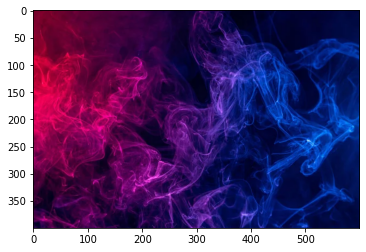

In [4]:
image = np.array(image[:, :, :3] * 255, dtype='uint8')
plt.imshow(image)
plt.show()

Podemos plotar o histograma da imagem sem o tratamento.

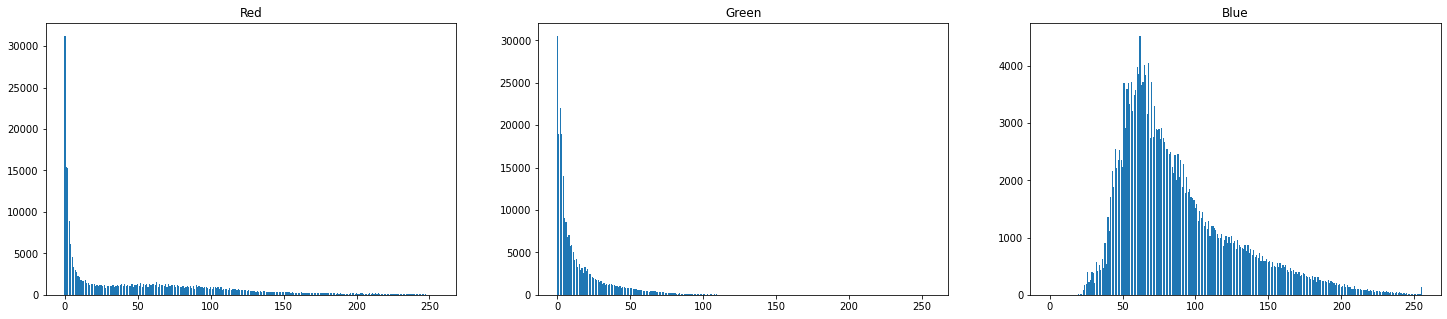

In [5]:
image_histogram(image)

Como podemos ver, a imagem não teve nenhuma alteração aparente, como era esperado uma vez que não alteramos nenhuma característica da imagem. Entretanto, agora iremos fazer a equalição da imagem, na primeira abordagem iremos equalizar o histograma de cada canal de cores separadamente.

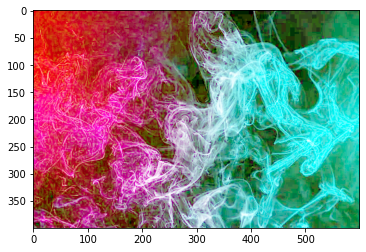

In [6]:
equalized_image = equalize_rgb_image(image)
plt.imshow(equalized_image)
plt.show()

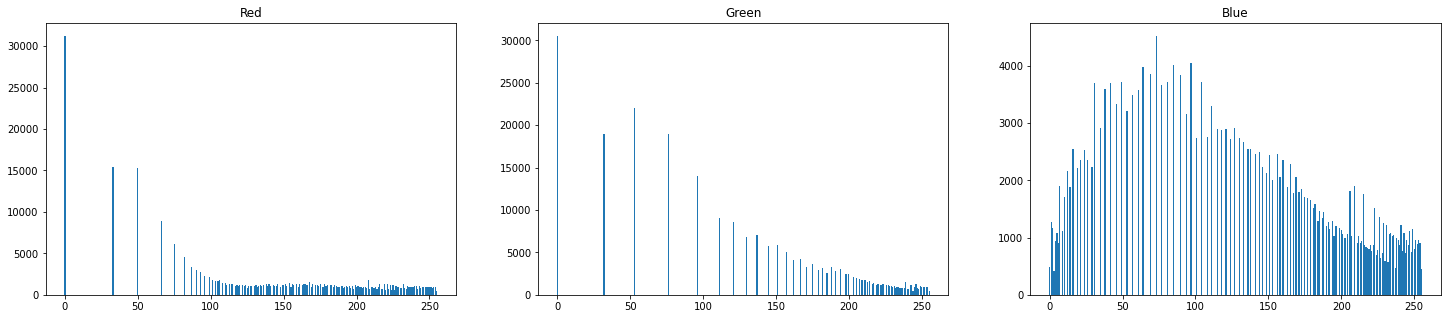

In [7]:
image_histogram(equalized_image)

Como podemos observar, a equalização de histograma teve sim um efeito sobre a imagem, entretanto, visualmente percebe-se que houve uma alteração das cores da imagem o que não é desejável, portanto, equalizar cada canal separadamente não é uma boa abordagem.

Uma abordagem mais promissora é equalizar o canal I da imagem após converter do domínio RGB para HSI.

In [8]:
hsi_equalized = equalize_hsi_image(image)
hsi_equalized = hsi_to_rgb(hsi_equalized)

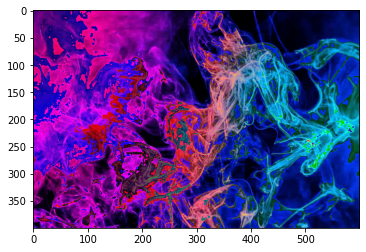

In [9]:
plt.imshow(hsi_equalized)
plt.show()

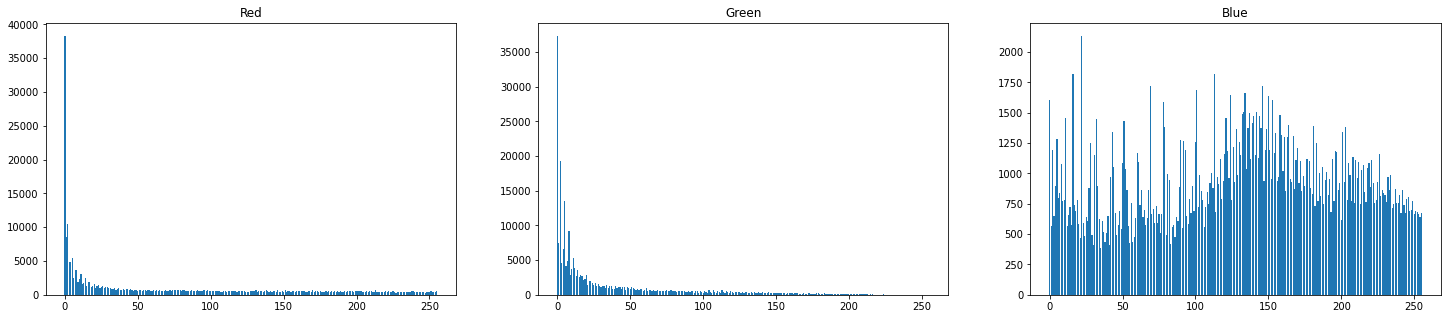

In [10]:
image_histogram(hsi_equalized)

Observa-se que a equalização, além de apresentar um histograma melhor dividido entre os canais, não proporcionou nenhuma espécie de alteração das tonalidades das imagem, uma vez que o canal de matiz não foi alterado, mostrando-se que utilizar o espaço de cores em HSI é uma abordagem muito mais consistente para esse tipo de tratamento.